목차

I. 프로젝트 준비단계

II. 프로젝트 : 주식 예측에 도전해 보자
  1> 삼성전자
  2> SK이노베이션
  3> 현대자동차
  4> KT

루브릭 평가 기준

1. 시계열의 안정성이 충분히 확인되었는가?.
  ==> 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
  
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

  ==> p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
  
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

  ==> 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨
  
소감

드디어 통계를 만났다.
드디어 시계열을 만났다.
드디어 주식을 만났다. 
......
통계도 몰라요, 시계열도 몰라요, 주식도 몰라요.. 
MAPE가 15% 미만인 걸로 나왔는데 왜 저렇게 된건지. 그저 프로그램에 감사할 뿐 ^^;;;;


# 프로젝트 준비단계

잘 알려진 작은 시계열 데이터를 토대로 시계열 데이터의 안정성의 개념을 시각적으로 따져보겠습니다.
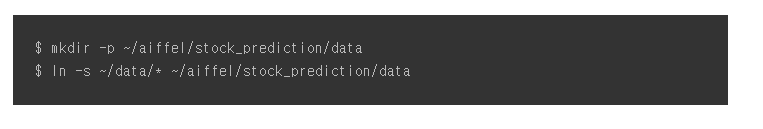


## 시계열 데이터 사례분석

### 시계열(Time Series) 생성

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')



In [6]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [7]:
# DataFrame에서 Date 컬럼을 index로 삼아 시계열을 생성
# 이번에는 Date를 index_col로 지정해 주었습니다. 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [8]:
ts1 = df['Temp']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts'라고 이름 붙여줍시다!
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

==> 명확하게 Series 객체를 가지고 진행

### 시계열 안정성의 정성적 분석

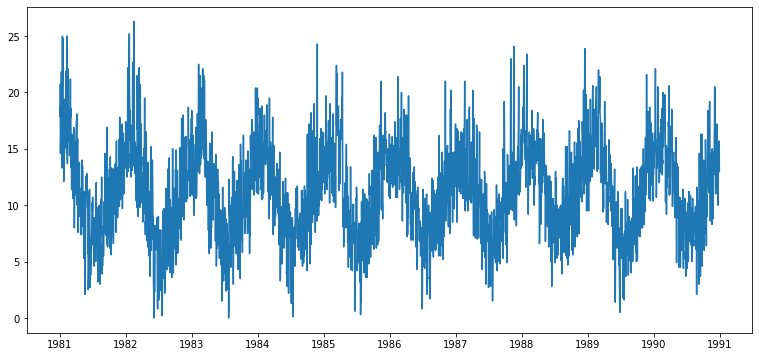

In [9]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

### 결측치 유무확인

하지만 분석에 들어가기 전에 잊지 말아야 할 단계가 하나 있습니다. 바로 결측치 유무 확인


In [10]:
ts1[ts1.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Temp, dtype: float64)

==> 만약 결측치가 있다면, 두 가지 방법으로 결측치를 처리해 줄 수 있습니다.

결측치가 있는 데이터를 모두 삭제(drop)

결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입

ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

이번 경우라면 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 보간하는 방법을 선택

Series([], Name: Temp, dtype: float64)


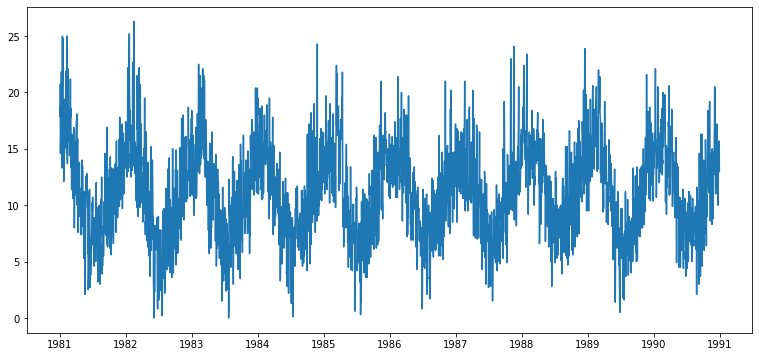

In [11]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts1[ts1.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts1)

In [12]:
# 시계열 데이터의 통계적 특성을 좀 더 명료하게 시각화
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


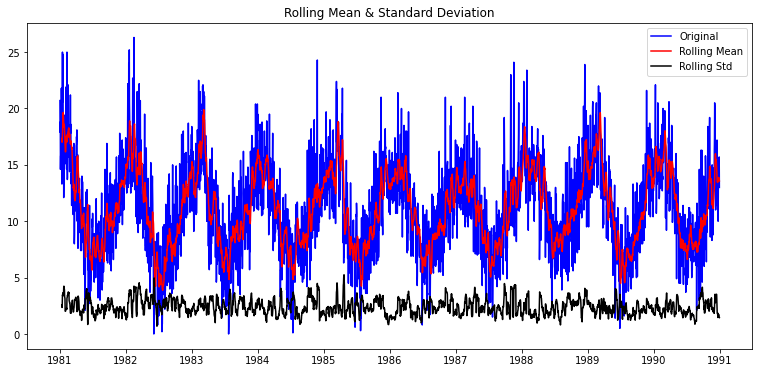

In [13]:
plot_rolling_statistics(ts1, window=12)

### 다른 데이터에 대해서도 비교해보자
이번에는 International airline passengers 데이터셋입니다. 
월별 항공 승객 수(천명 단위)의 시계열 데이터인데 기온 변화 데이터셋과는 좀 다른 패턴이 나타나지 않을까요? 
위와 동일한 방법으로 분석해 보겠습니다.

In [14]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


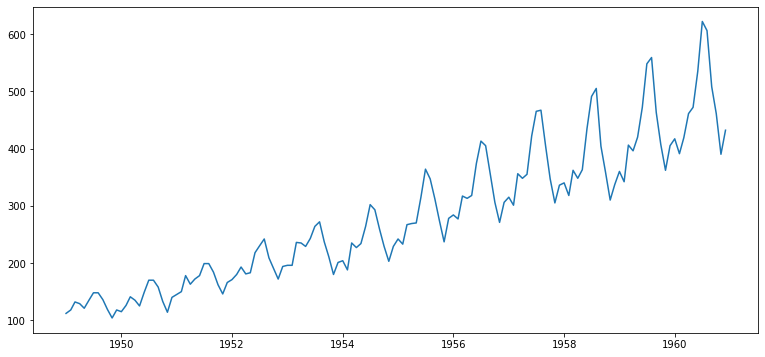

In [15]:
ts2 = df['Passengers']
plt.plot(ts2)

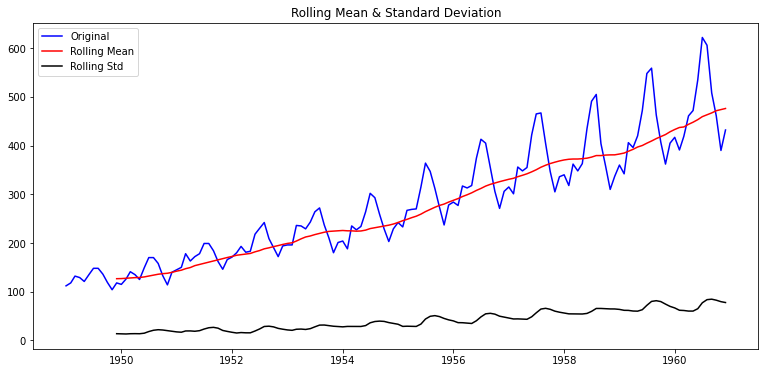

In [16]:
plot_rolling_statistics(ts2, window=12)

## Stationary 여부를 체크하는 통계적 방법


### Augmented Dickey-Fuller Test

Augmented Dickey-Fuller Test(ADF Test) 라는 시계열 데이터의 안정성(stationary)을 테스트하는 통계적 방법을 소개
ADF Test의 세부 알고리즘을 간단히 보고, 

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 손쉽게 ADF Test의 결과를 이용할 것입니다. 

아래는 statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 

주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드입니다.


In [18]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    


In [19]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


==> ts1(Daily Minimum Temperatures in Melbourne)시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 0에 가깝게 나타났습니다.

따라서 이 귀무가설은 기각되고, 이 시계열은 안정적 시계열이라는 대립가설이 채택됩니다.

In [20]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


==> ts2(International airline passengers) 시계열이 안정적이지 않다는 귀무가설은 p-value가 거의 1에 가깝게 나타났습니다.

p-value가 1에 가깝다는 것이 이 귀무가설(주어진 시계열 데이터가 안정적이지 않다.) 이 옳다는 직접적인 증거는 아닙니다.

하지만 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없습니다.

## 시계열 예측의 기본 아이디어 : Stationary하게 만들 방법은 없을까?

안정적이지 않은 시계열을 분석하려면 이것을 안정적인 시계열로 바꾸어 내야 합니다. 이것이 어떻게 가능할까요?

크게 두 가지가 있습니다.

1> 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도

2> 시계열 분해(Time series decomposition) 기법을 적용

### 1. 보다 Stationary한 시계열로 가공해 가기 ==> 2. 시계열 분해(Time series decomposition)바로 넘어가도 됨

#### 1-1. 로그함수 변환

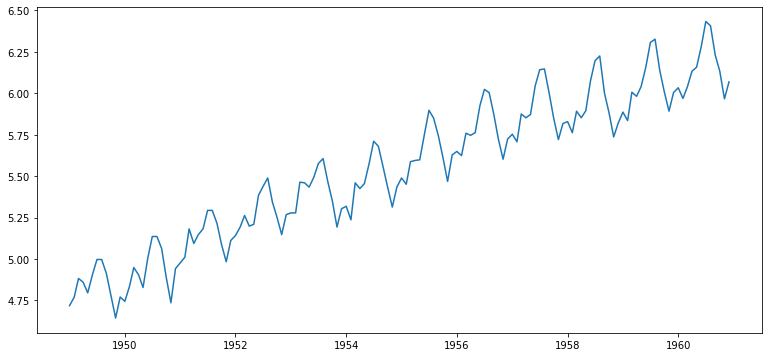

In [23]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [25]:
#로그 변환의 효과가 어떠했는지 따져 보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


==> p-value가 0.42로 무려 절반 이상 줄어들었습니다. 

정성적으로도 시간 추이에 따른 분산이 일정해진 것을 확인할 수 있습니다. 

아주 효과적인 변환이었던 것 같습니다. 하지만 아직은 갈 길이 멉니다. 

가장 두드러지는 문제점은 시간 추이에 따라 평균이 계속 증가한다는 점입니다.

#### 1-2. Moving average 제거 - 추세(Trend) 상쇄하기

시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다. 

이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주면 어떨까요?

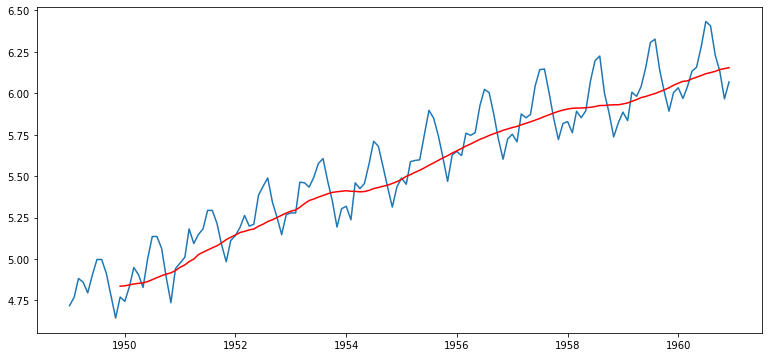

In [26]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [27]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

==> 우리가 관심을 가진 ts_log_moving_avg에 거의 도달했습니다. 

그런데 문제는 Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다는 점입니다.

이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 줍니다.

In [28]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

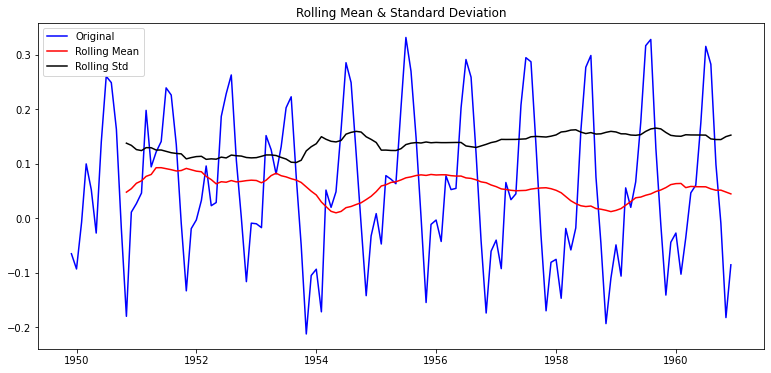

In [29]:
plot_rolling_statistics(ts_log_moving_avg)

In [30]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


==> 드디어 p-value가 0.02 수준이 되었습니다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있겠습니다.

그러나 지금까지의 접근에서 한 가지 숨겨진 문제점이 있습니다.

바로 Moving Average를 계산하는 window=12로 정확하게 지정해 주어야 한다는 점입니다.


In [32]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)


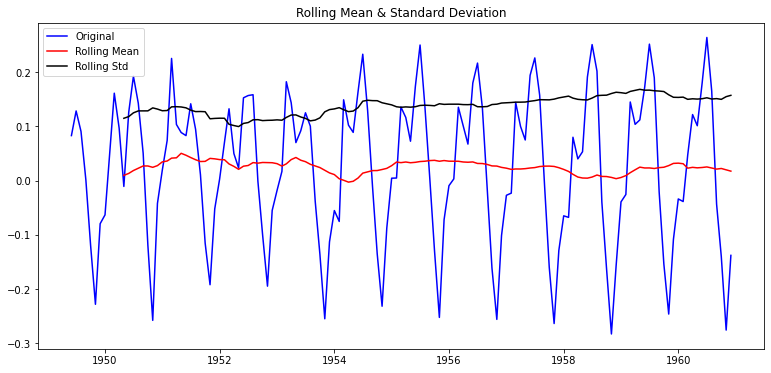

In [33]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [34]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -2.273822
p-value                          0.180550
#Lags Used                      14.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


==> 그래프를 정성적으로 분석해서는 window=12일 때와 별 차이를 느낄 수 없지만 

Augmented Dickey-Fuller Test의 결과 p-value는 0.18 수준이어서 아직도 안정적 시계열이라고 말할 수 없게 되었습니다.

이 데이터셋은 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12가 적당하다는 것을 추측할 수도 있을 것 같습니다만, 

moving average를 고려할 때는 rolling mean을 구하기 위한 window 크기를 결정하는 것이 매우 중요하다는 것을 기억해 둡시다.

이제 시간의 추이에 따라 평균이 증가하는 trend를 제거하였습니다. 그러나 여전히 안정적인 시계열이라고 하기에는 마음에 걸리는 부분이 있습니다.

#### 1-3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기

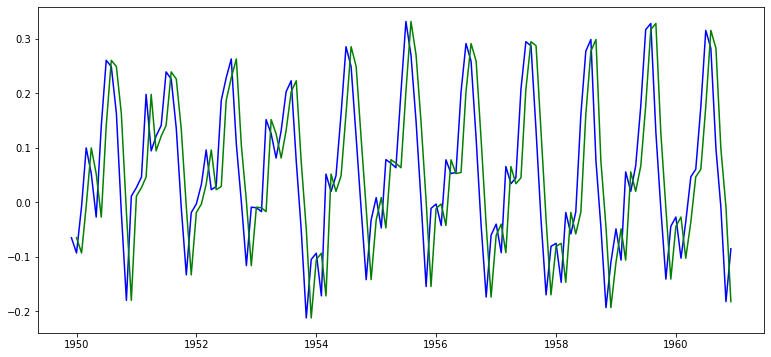

In [35]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

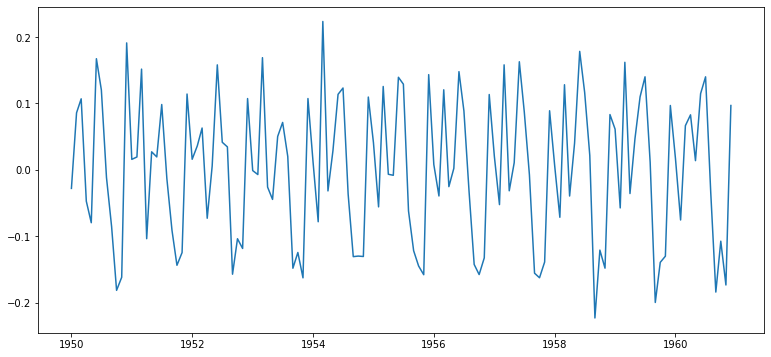

In [36]:
# 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

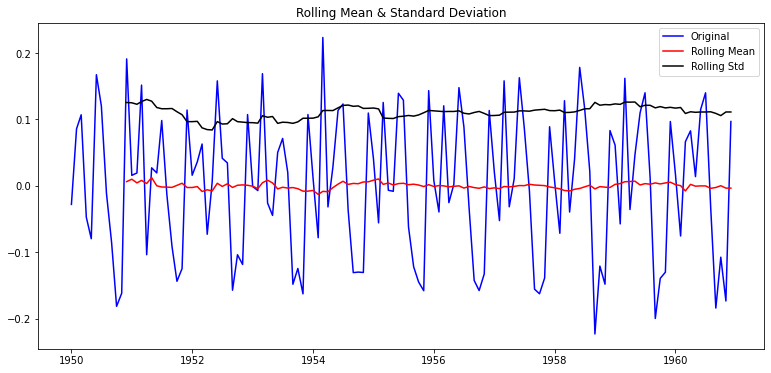

In [37]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)


In [38]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


==> 이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과, p-value가 약 0.022 에서 0.0019로 1/10 정도로 줄었습니다.

### 2. 시계열 분해(Time series decomposition) => 한방에 해결

tatsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있습니다. 

이 기능을 활용하면 우리가 위에서 직접 수행했던 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 됩니다. 

이번에는 위에서 구했던 로그 변환 단계(ts_log)에서부터 출발해 봅시다.

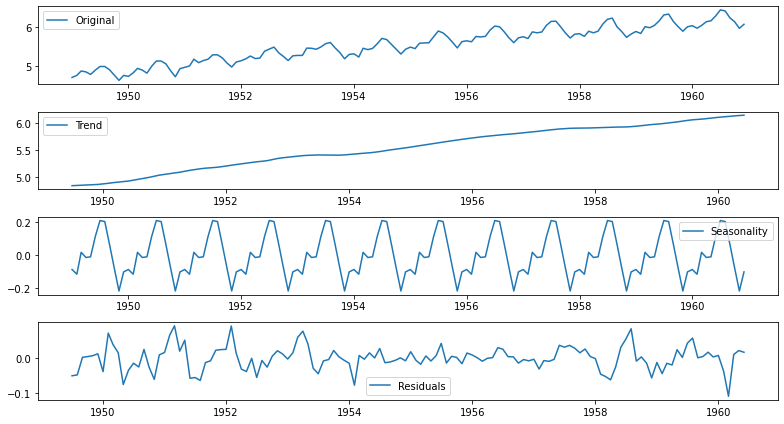

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

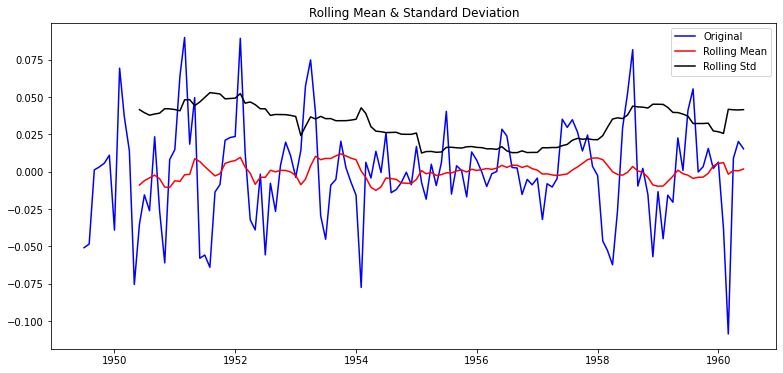

In [41]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [42]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


==> Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다. 

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다. 

어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까요? 

물론 그렇긴 합니다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 이해해 주시면 좋겠습니다.

## ARIMA 모델의 개념

앞에서 시계열 데이터가 Trend와 Seasonality, Residual로 분해되는 것을 확인했습니다, 

또, Trend와 Seasonality를 잘 분리해 낸 경우 Residual이 예측력 있는 안정적인 시계열 데이터가 되는 것을 확인하였습니다.

ARIMA(Autoregressive Integrated Moving Average)를 사용하면 이 원리를 이용해 시계열 데이터 예측 모델을 자동으로 만들 수 있습니다.

ARIMA는 AR(Autoregressive) + I(Integrated) + MA(Moving Average) 라고 할 수 있는데, 

각각의 개념을 살펴보면 지금까지 배운 개념과 닮아 있음을 알게 됩니다

### ARIMA 모델의 모수 p, q, d - ????????무슨말씀인지
statsmodels에서 제공하는 ACF와 PACF 플로팅 기능을 사용할 것

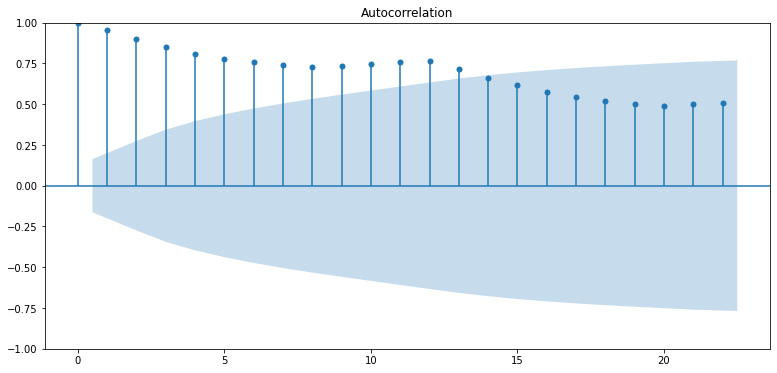

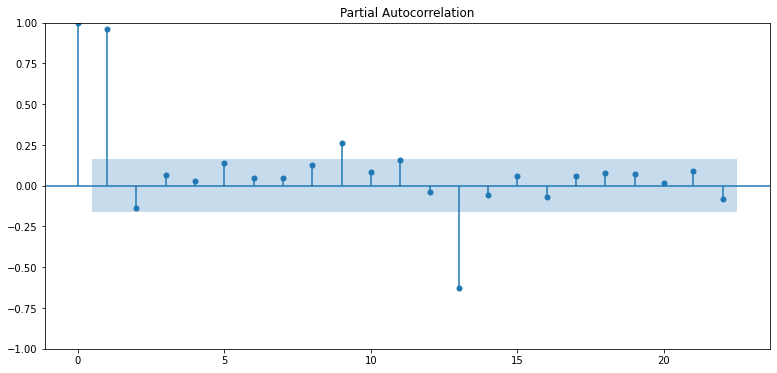

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

==> ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음을 통계학적으로 설명
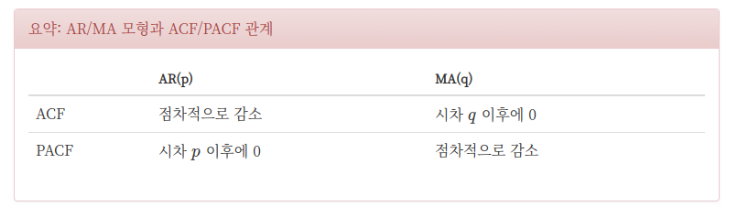

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


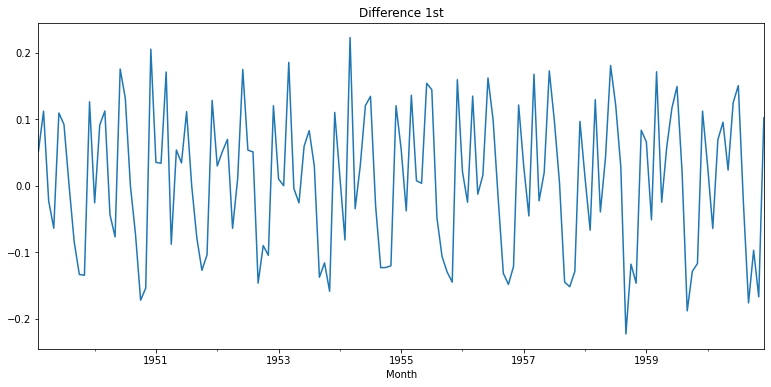

In [47]:
# d를 구하기 위해서는 좀 다른 접근이 필요합니다. d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 합니다
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


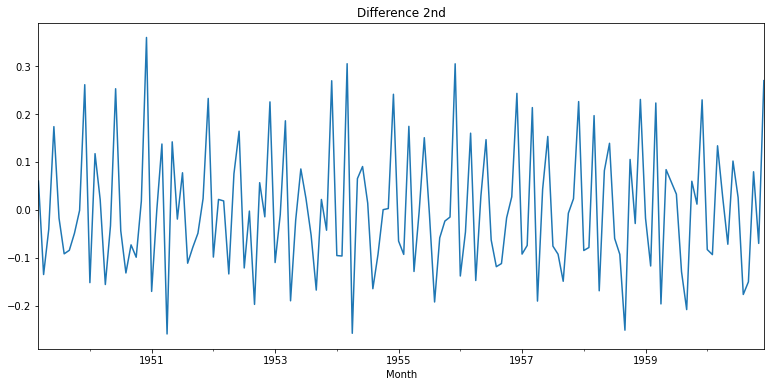

In [48]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 학습 데이터 분리
시계열 데이터에서 학습 데이터와 테스트 데이터를 분리해 봅시다. 

분리 비율은 학습과 테스트에 9:1로 하겠습니다. 

시계열 예측이니만큼 가장 나중 데이터를 테스트용으로 사용하는 것이 타당할 것입니다.

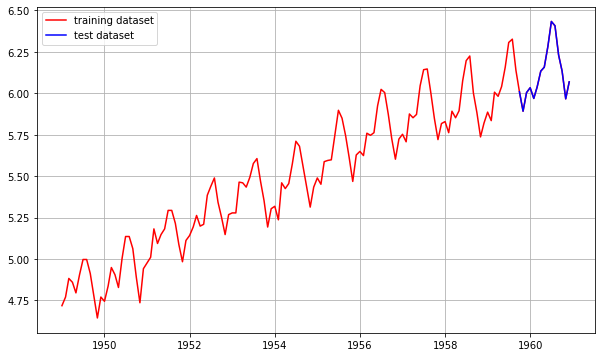

In [49]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [50]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## ARIMA 모델 훈련과 추론

In [51]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.951
Date:                Wed, 09 Feb 2022   AIC                           -409.902
Time:                        20:22:43   BIC                           -367.121
Sample:                    01-01-1949   HQIC                          -392.520
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2752      0.081     -3.387      0.001      -0.434      -0.116
ar.L2         -0.0124      0.109     -0.114      0.909      -0.225       0.200
ar.L3          0.0002      0.046      0.005      0.9

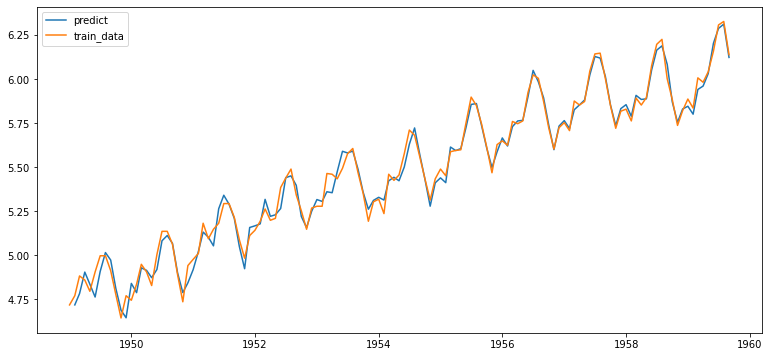

In [52]:
# 시각적으로 확인
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

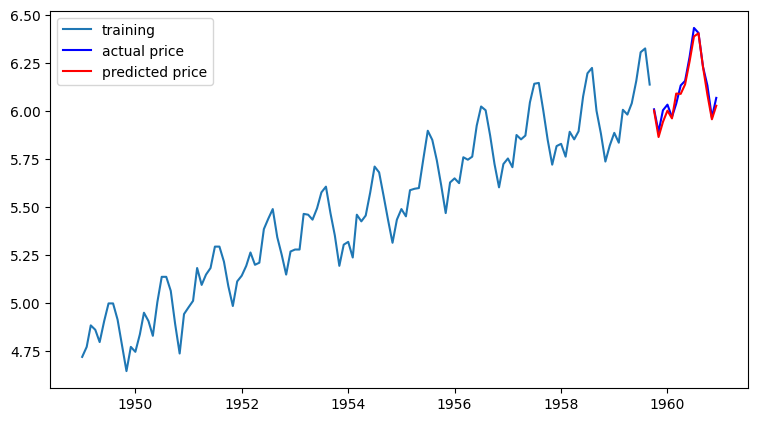

In [53]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [54]:
#시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있습니다. 
#np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산합니다.
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  231.97320956929948
MAE:  12.424959605677085
RMSE:  15.230666747365314
MAPE: 2.74%


==> 최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 10% 정도의 오차율을 보입니다. 

썩 만족스럽지 않은데, 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을지 모르겠습니다.

p=14을 줄 경우 MAPE가 2% 정도로 내려갑니다.
조금더 다양한 테스트를 거쳐 최적화된 모델을 만들어 보시면 좋을것 같습니다.

# 프로젝트 : 주식 예측에 도전해 보자

# 삼성전자에 대한 주식 시세를 예측
 Yahoo Finance에서 오늘 사용할 데이터셋을 다운로드

## STEP 1 : 시계열 데이터 준비

In [57]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
결측치 처리

로그 변환

In [58]:

# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [59]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석

정량적 Augmented Dicky-Fuller Test

시계열 분해(Time Series Decomposition)

Residual 안정성 확인

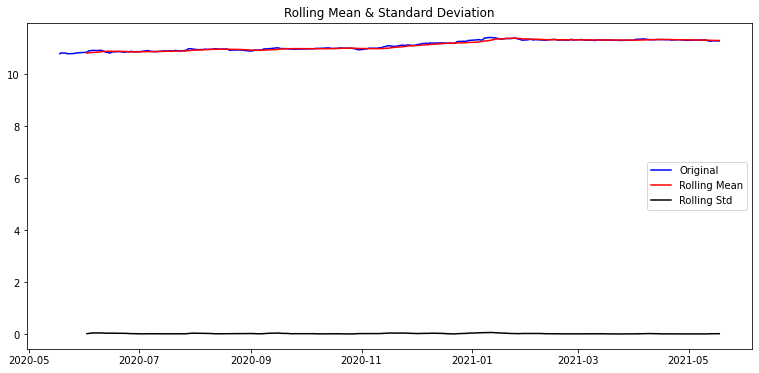

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


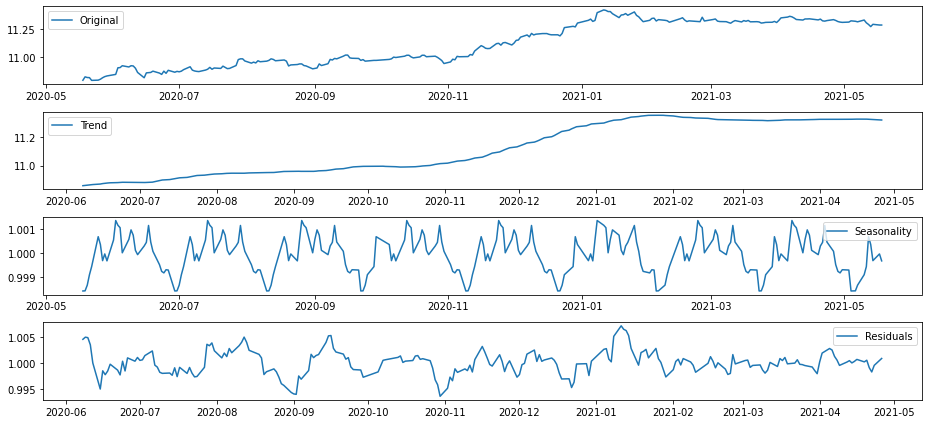

In [60]:

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [61]:

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

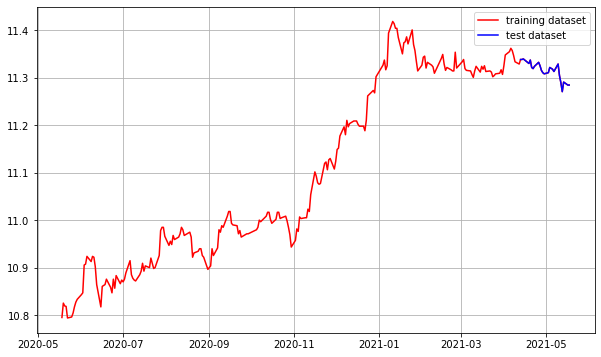

In [62]:

train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


## STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

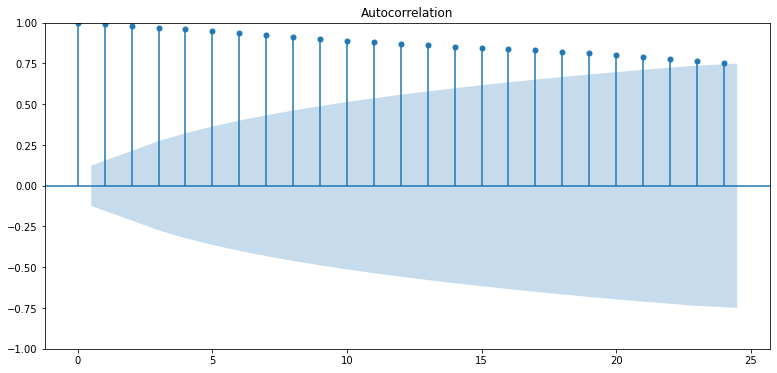

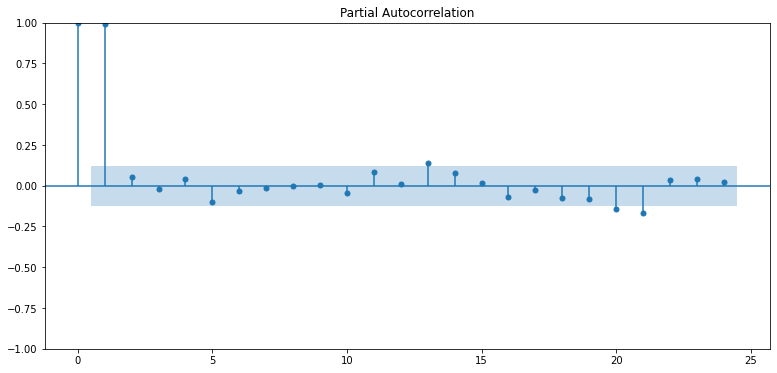

In [63]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


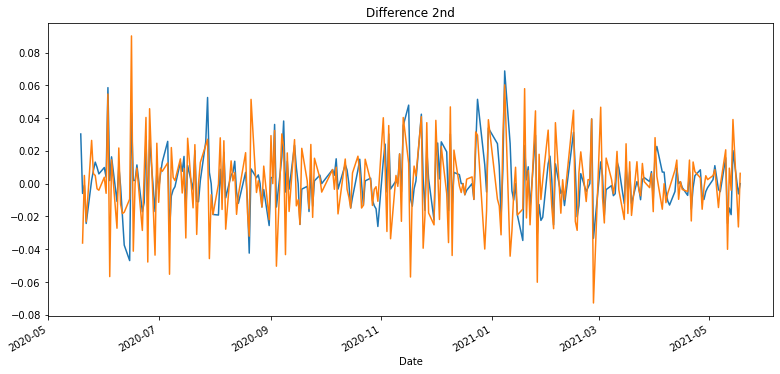

In [64]:

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련

모델 테스트 및 플로팅

최종 예측 모델 정확도 측정(MAPE)

In [65]:

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Wed, 09 Feb 2022   AIC                          -1156.722
Time:                        20:38:32   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

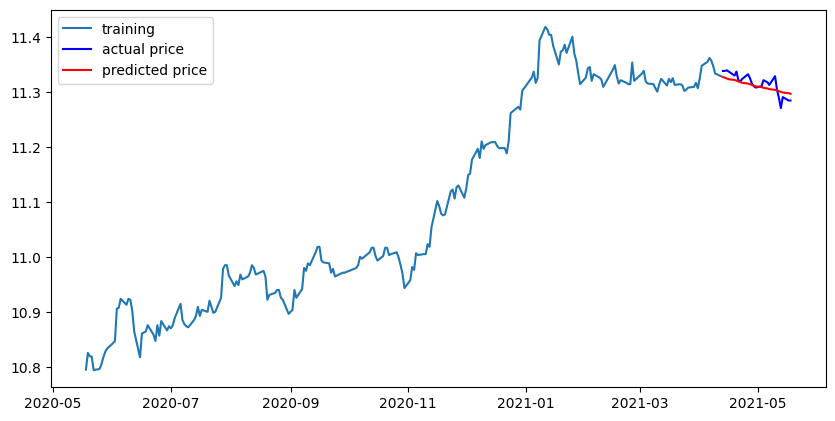

In [66]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [67]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# SK이노베이션 주식

# SK 에 대한 주식 시세를 예측¶
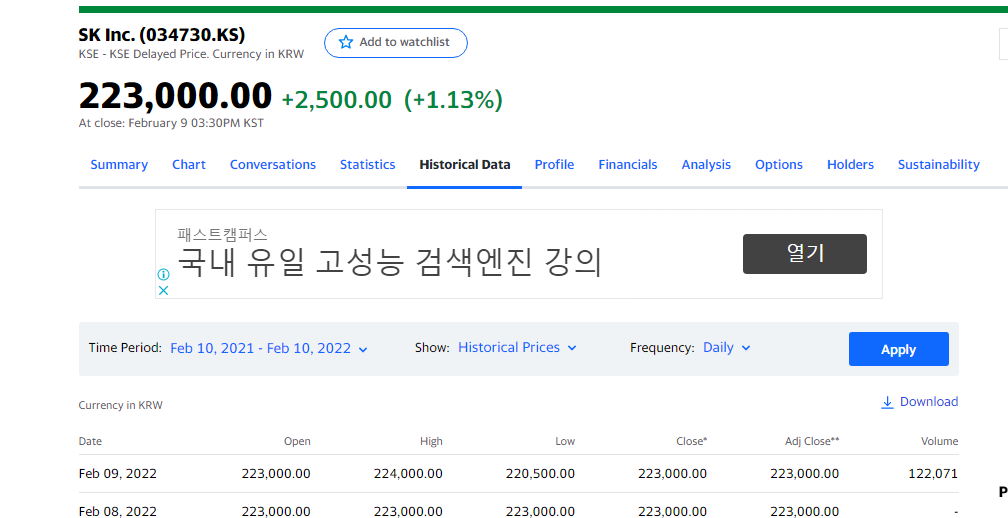

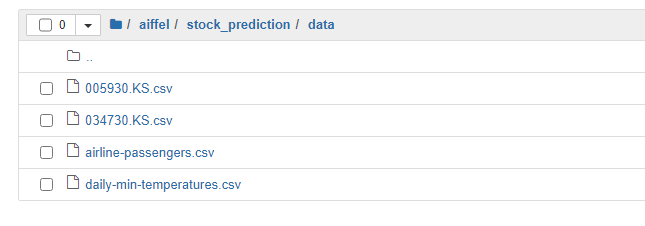

## STEP 1 : 시계열 데이터 준비

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/034730.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    309500.0
2021-02-15    302000.0
2021-02-16    303500.0
2021-02-17    298500.0
2021-02-18    289500.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
결측치 처리

로그 변환

In [69]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [70]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석

정량적 Augmented Dicky-Fuller Test

시계열 분해(Time Series Decomposition)

Residual 안정성 확인

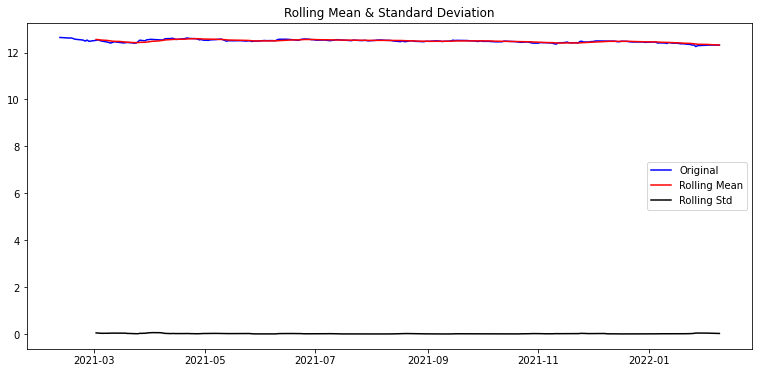

Results of Dickey-Fuller Test:
Test Statistic                  -1.308396
p-value                          0.625322
#Lags Used                       4.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


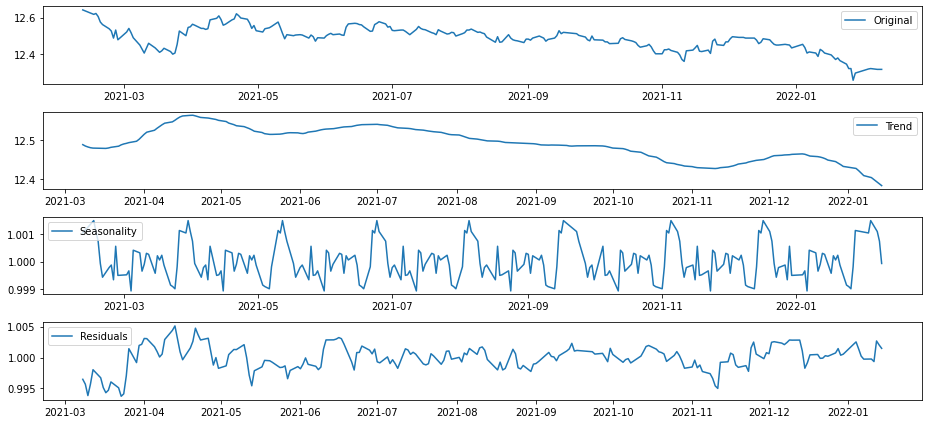

In [71]:

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


In [72]:

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


Results of Dickey-Fuller Test:
Test Statistic                -5.902979e+00
p-value                        2.750160e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.010000e+02
Critical Value (1%)           -3.463309e+00
Critical Value (5%)           -2.876029e+00
Critical Value (10%)          -2.574493e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

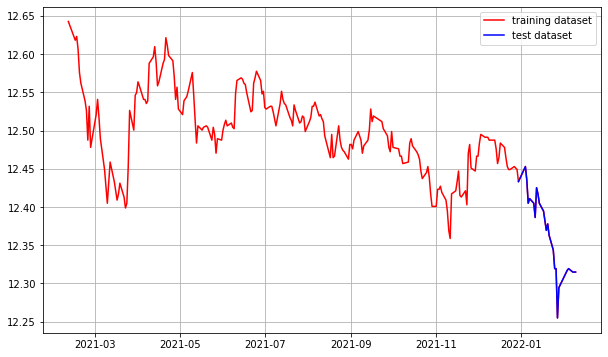

In [73]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

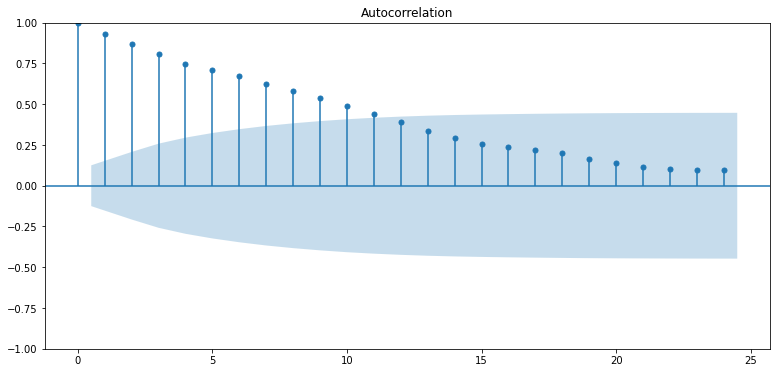

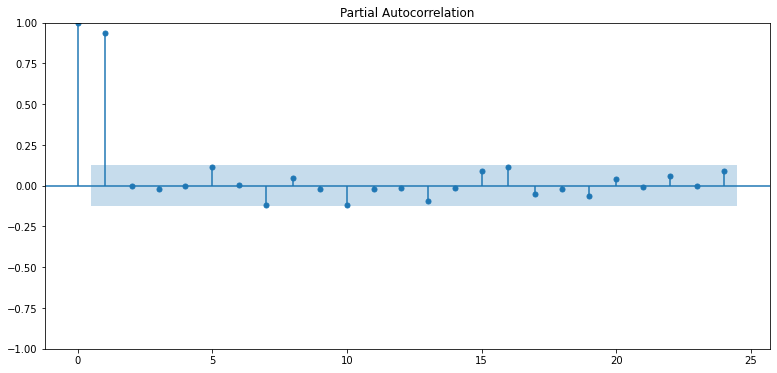

In [75]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -9.560528e+00
p-value                        2.432827e-16
#Lags Used                     3.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.077642e+01
p-value                        2.313635e-19
#Lags Used                     8.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


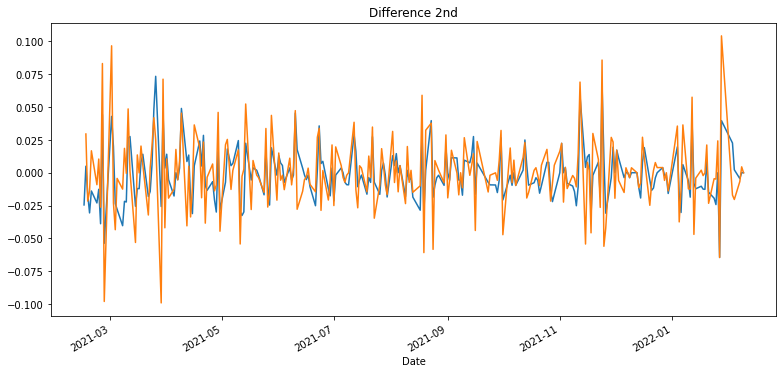

In [76]:

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련

모델 테스트 및 플로팅

최종 예측 모델 정확도 측정(MAPE)

In [77]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 559.973
Date:                Wed, 09 Feb 2022   AIC                          -1109.946
Time:                        20:48:01   BIC                          -1092.977
Sample:                             0   HQIC                         -1103.093
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5051      0.019    642.783      0.000      12.467      12.543
ar.L1          0.8031      1.283      0.626      0.531      -1.711       3.318
ar.L2          0.1305      1.215      0.107      0.9

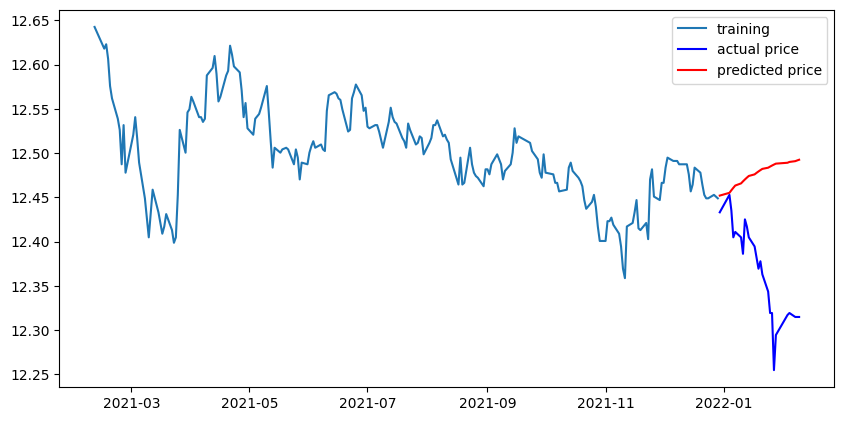

In [78]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [79]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  949941446.2693841
MAE:  26985.125087515007
RMSE:  30821.12013326875
MAPE: 11.83%


# 현대자동차 주식

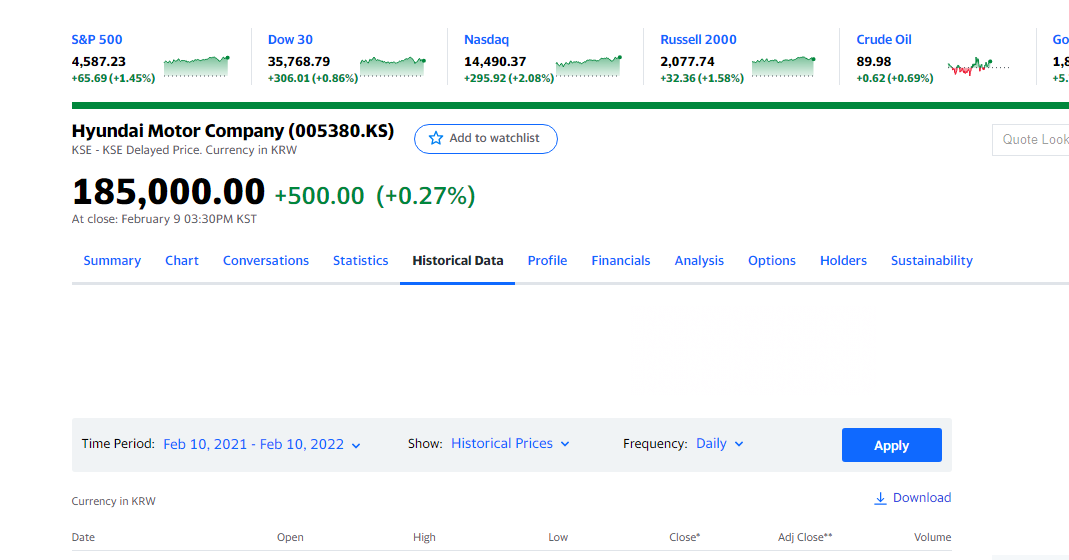

## STEP 1 : 시계열 데이터 준비

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005380.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-10    245000.0
2021-02-15    247500.0
2021-02-16    247500.0
2021-02-17    243500.0
2021-02-18    235500.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
결측치 처리

로그 변환

In [88]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [89]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석

정량적 Augmented Dicky-Fuller Test

시계열 분해(Time Series Decomposition)

Residual 안정성 확인

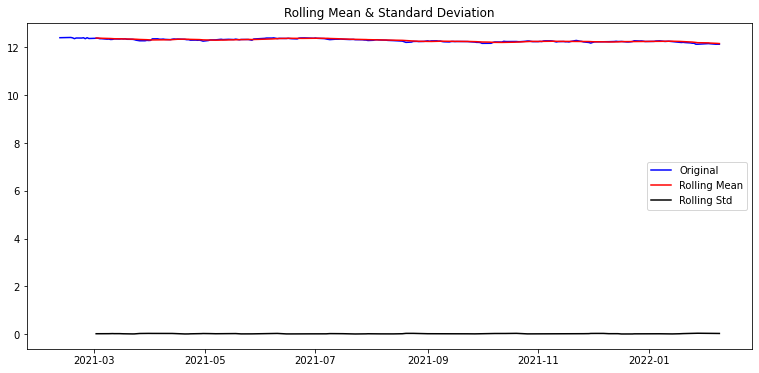

Results of Dickey-Fuller Test:
Test Statistic                  -1.426130
p-value                          0.569687
#Lags Used                       2.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


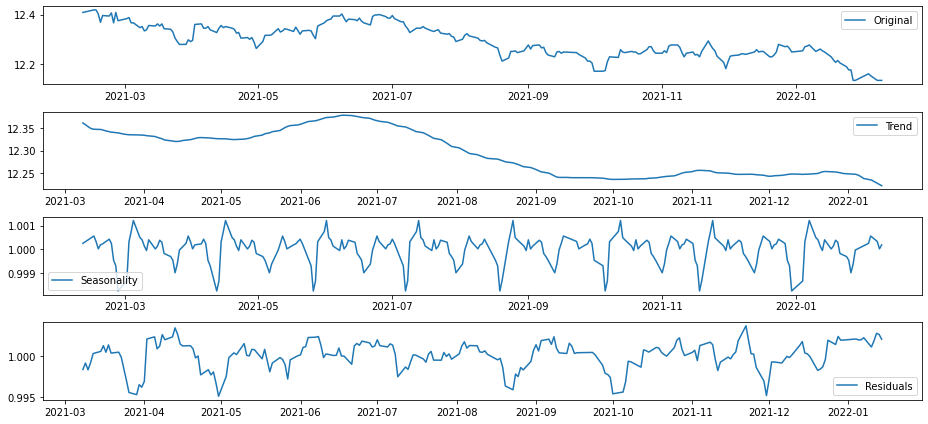

In [90]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [91]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.849368e+00
p-value                        3.619660e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

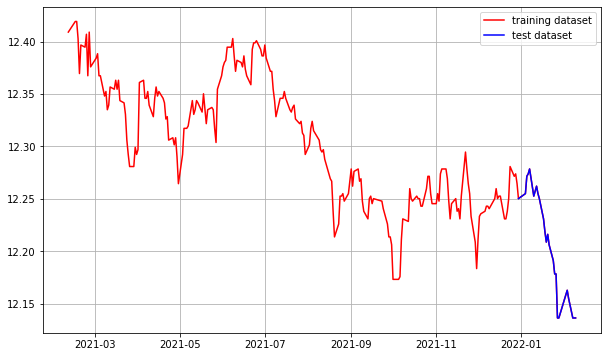

In [92]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

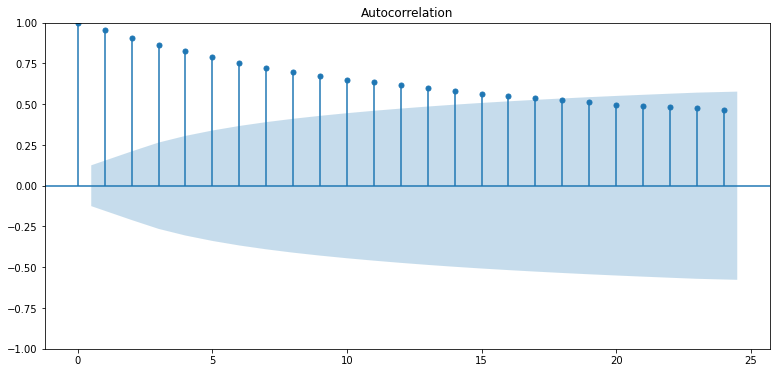

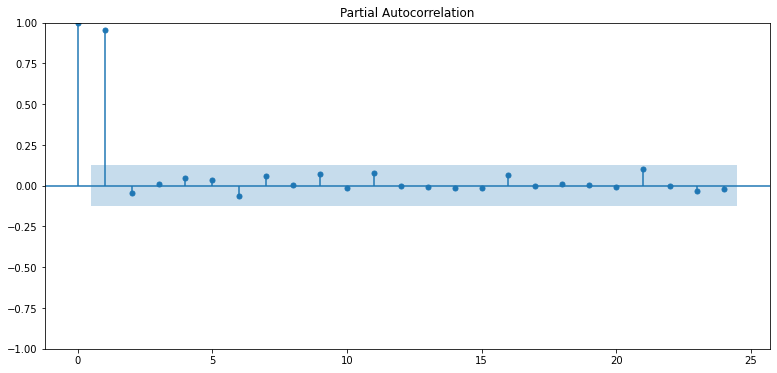

In [93]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.164510e+01
p-value                        2.101500e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.467759e+00
p-value                        1.506277e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


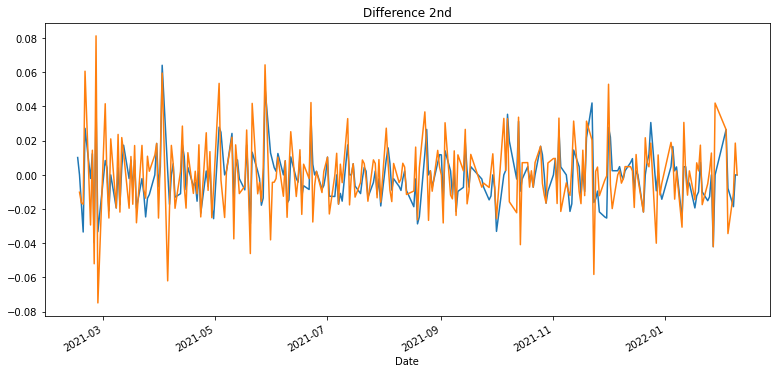

In [94]:

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련

모델 테스트 및 플로팅

최종 예측 모델 정확도 측정(MAPE)

In [95]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  220
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 610.678
Date:                Wed, 09 Feb 2022   AIC                          -1211.356
Time:                        21:11:54   BIC                          -1194.387
Sample:                             0   HQIC                         -1204.503
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3117      0.027    461.321      0.000      12.259      12.364
ar.L1          0.1990      0.941      0.211      0.833      -1.646       2.044
ar.L2          0.7471      0.915      0.817      0.4

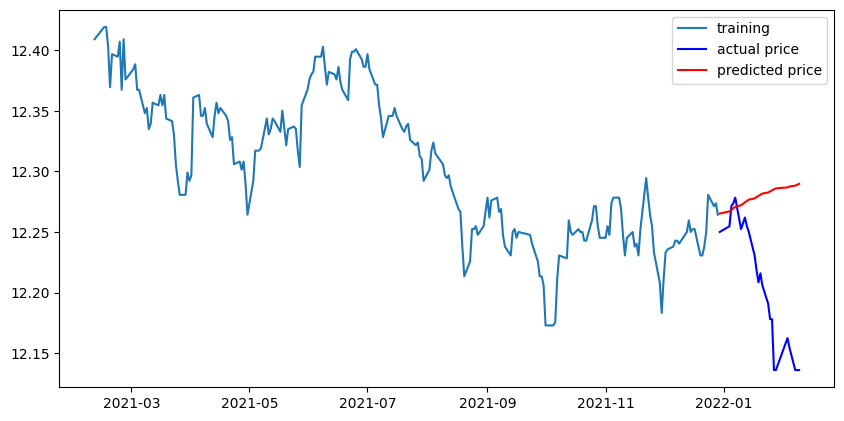

In [96]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  333448668.9098051
MAE:  14517.252255777748
RMSE:  18260.57690517485
MAPE: 7.52%


# KT 주식

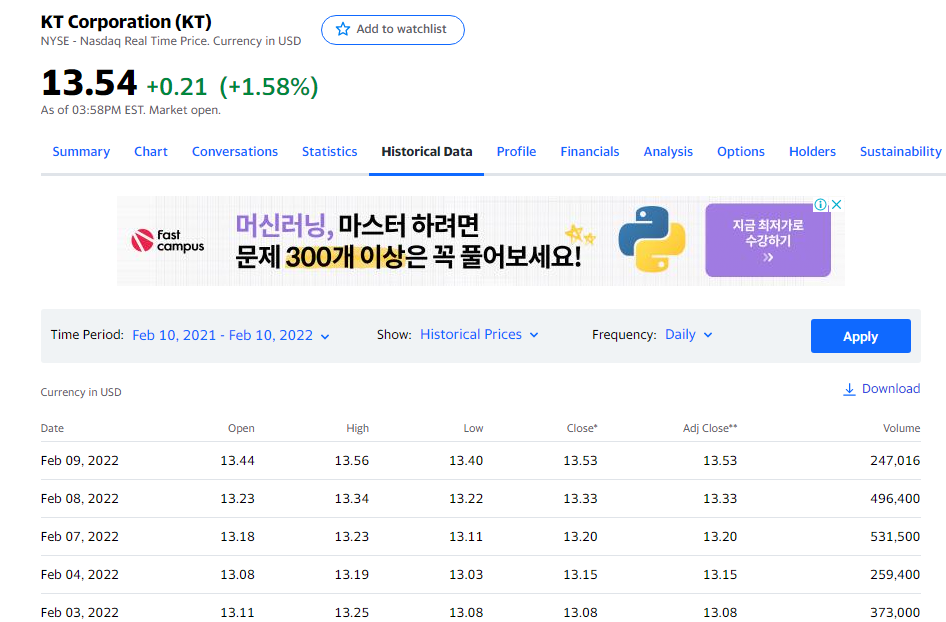

## STEP 1 : 시계열 데이터 준비

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/KT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-09    10.62
2021-02-10    10.77
2021-02-11    11.26
2021-02-12    11.03
2021-02-16    11.80
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행
결측치 처리

로그 변환

In [100]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [101]:
# 로그 변환 시도 
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석

정량적 Augmented Dicky-Fuller Test

시계열 분해(Time Series Decomposition)

Residual 안정성 확인

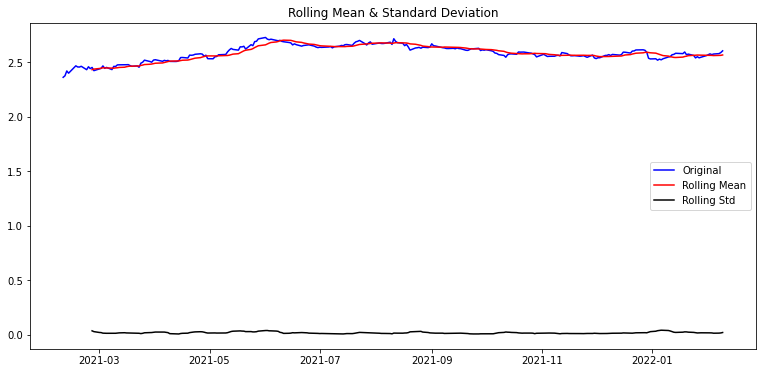

Results of Dickey-Fuller Test:
Test Statistic                  -2.439778
p-value                          0.130823
#Lags Used                       2.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


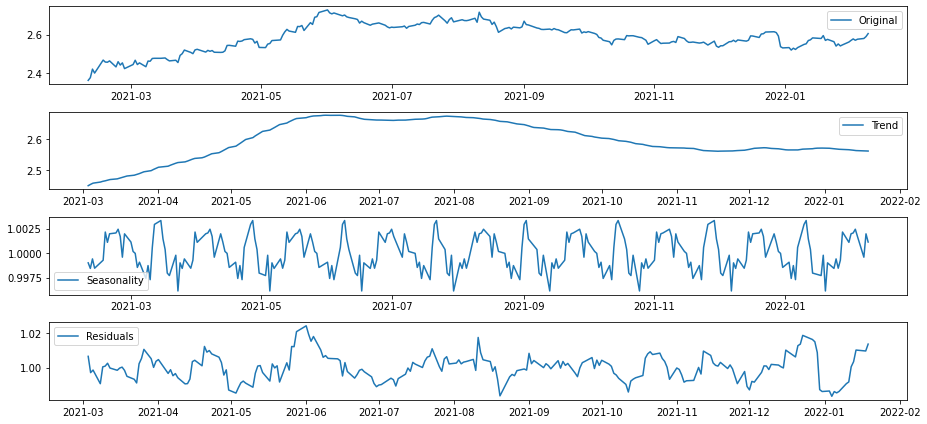

In [102]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [103]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.286319e+00
p-value                        3.690604e-08
#Lags Used                     5.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
학습, 테스트 데이터셋 분리

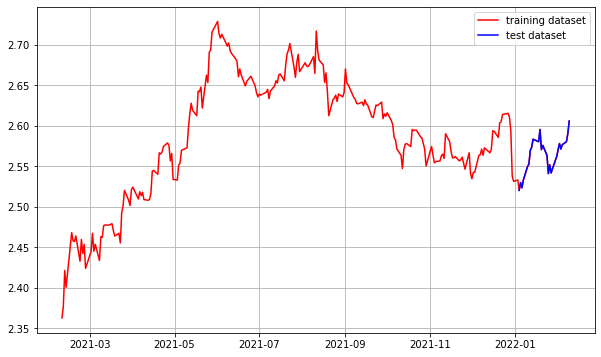

In [105]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기
ACF, PACF 그려보기 -> p,q 구하기

차분 안정성 확인 -> d 구하기

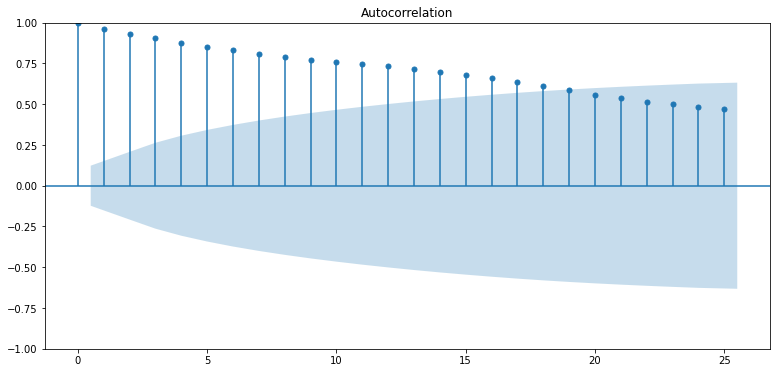

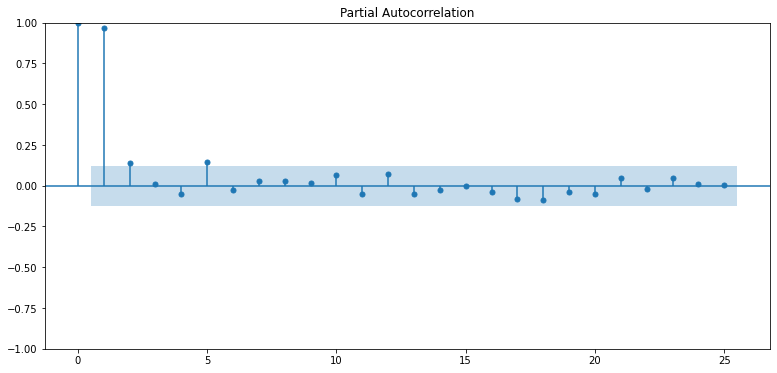

In [106]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.094557e+01
p-value                        9.065411e-20
#Lags Used                     1.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.121423e+00
p-value                        1.153312e-12
#Lags Used                     1.500000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


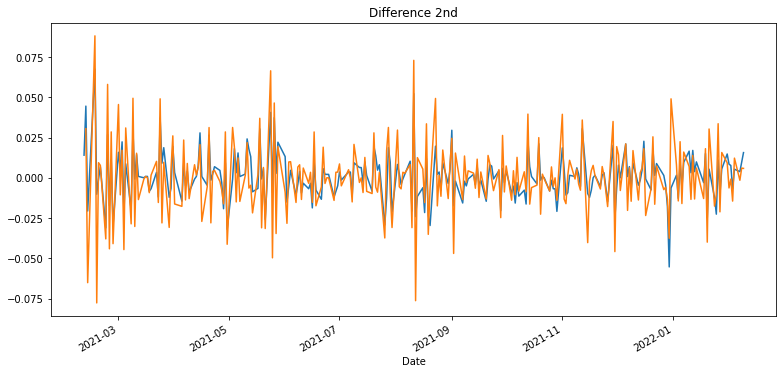

In [107]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련

모델 테스트 및 플로팅

최종 예측 모델 정확도 측정(MAPE)

In [108]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 636.906
Date:                Wed, 09 Feb 2022   AIC                          -1263.812
Time:                        21:18:42   BIC                          -1246.666
Sample:                             0   HQIC                         -1256.894
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5293      0.040     62.723      0.000       2.450       2.608
ar.L1          0.1722      0.117      1.471      0.141      -0.057       0.402
ar.L2          0.8033      0.116      6.935      0.0

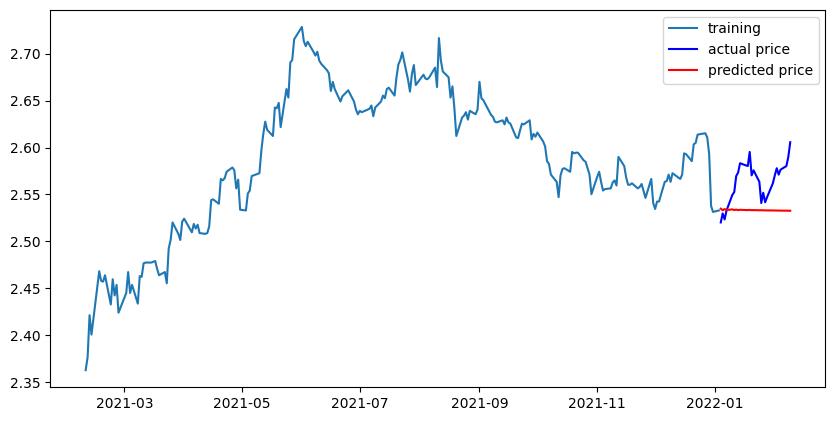

In [109]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [110]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.22835698744102834
MAE:  0.4100458736829224
RMSE:  0.477867123205843
MAPE: 3.12%
